<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/Kalman_Filters_for_Nifty_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b
!pip install ffn

     |████████████████████████████████| 228 kB 5.1 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=74a4a1ce9e93c705fe1a3e217f76f9237512cc0c991881a27b57b4fc25f647c7
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman
     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 88 kB 3.6 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=e73141d8e030dfd779de2f0771ee6a1d4be964ed071c1bbce04cd316891d478a
  Stored in directory: /root/.cache/pip/wheels/b1/49/60/e674e28ae57160651c6198b76e1714a0b175e44e022fcd5137
Successfully built pandas-ta


In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
import ffn
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

[*********************100%***********************]  1 of 1 completed


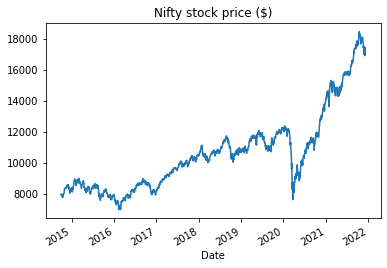

In [3]:
nifty_df = yf.download('^nsei',start='2014-10-01') # 2018
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [4]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [5]:
df = nifty_df[['Adj Close']]


mean 16206.368398655184


Text(0.5, 0, 'Days')

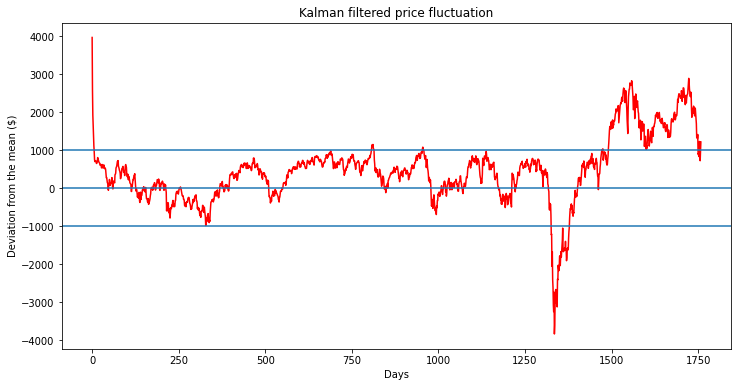

In [6]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [7]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [8]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=26,slow=50,signal=18, append=True)

print()

In [9]:
nifty=nifty.set_index('date')

In [10]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18
date,,,,,,,,
2021-12-07,982.616909,1448.565097,490.538564,1693.834379,1203.295815,-276.937955,-130.619211,-146.318745
2021-12-08,1222.481211,1403.687839,466.335541,1636.855610,1170.520069,-275.318480,-115.420816,-159.897664


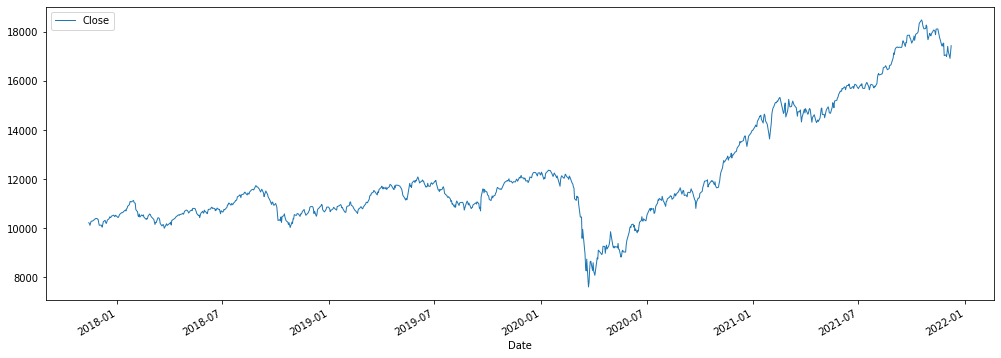

In [11]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

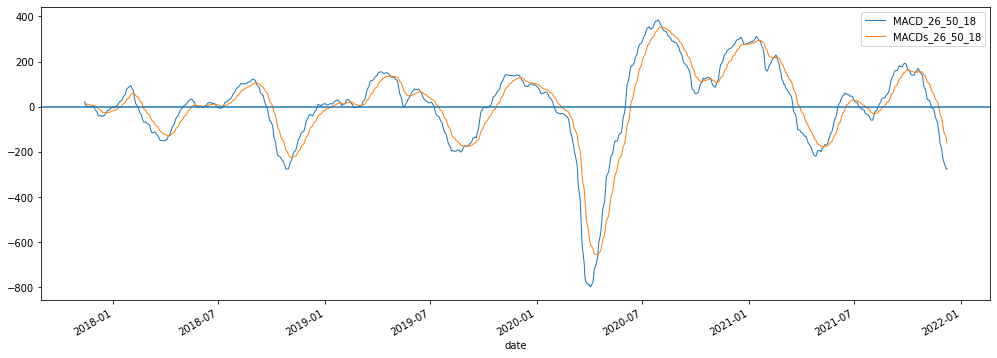

In [12]:
nifty[['MACD_26_50_18','MACDs_26_50_18']][-1000:].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);

In [13]:
nifty['slope']=abs(nifty['MACD_26_50_18'].diff(5))
nifty['slope']=np.where(nifty['slope']<=10,0,nifty['slope'])
nifty['slope_s']=abs(nifty['MACDs_26_50_18'].diff(5))
nifty['slope_s']=np.where(nifty['slope_s']<=10,0,nifty['slope_s'])

In [14]:
nifty_df['Buy_ind'] = np.where((nifty['slope_s']>0), 1, 0)
#nifty['Sell_ind'] = np.where((nifty['slope_s']==-1), 0, 1)

In [15]:
nifty_df.Close.tail(1)

Date
2021-12-08    17428.849609
Name: Close, dtype: float64

In [16]:
l=-600

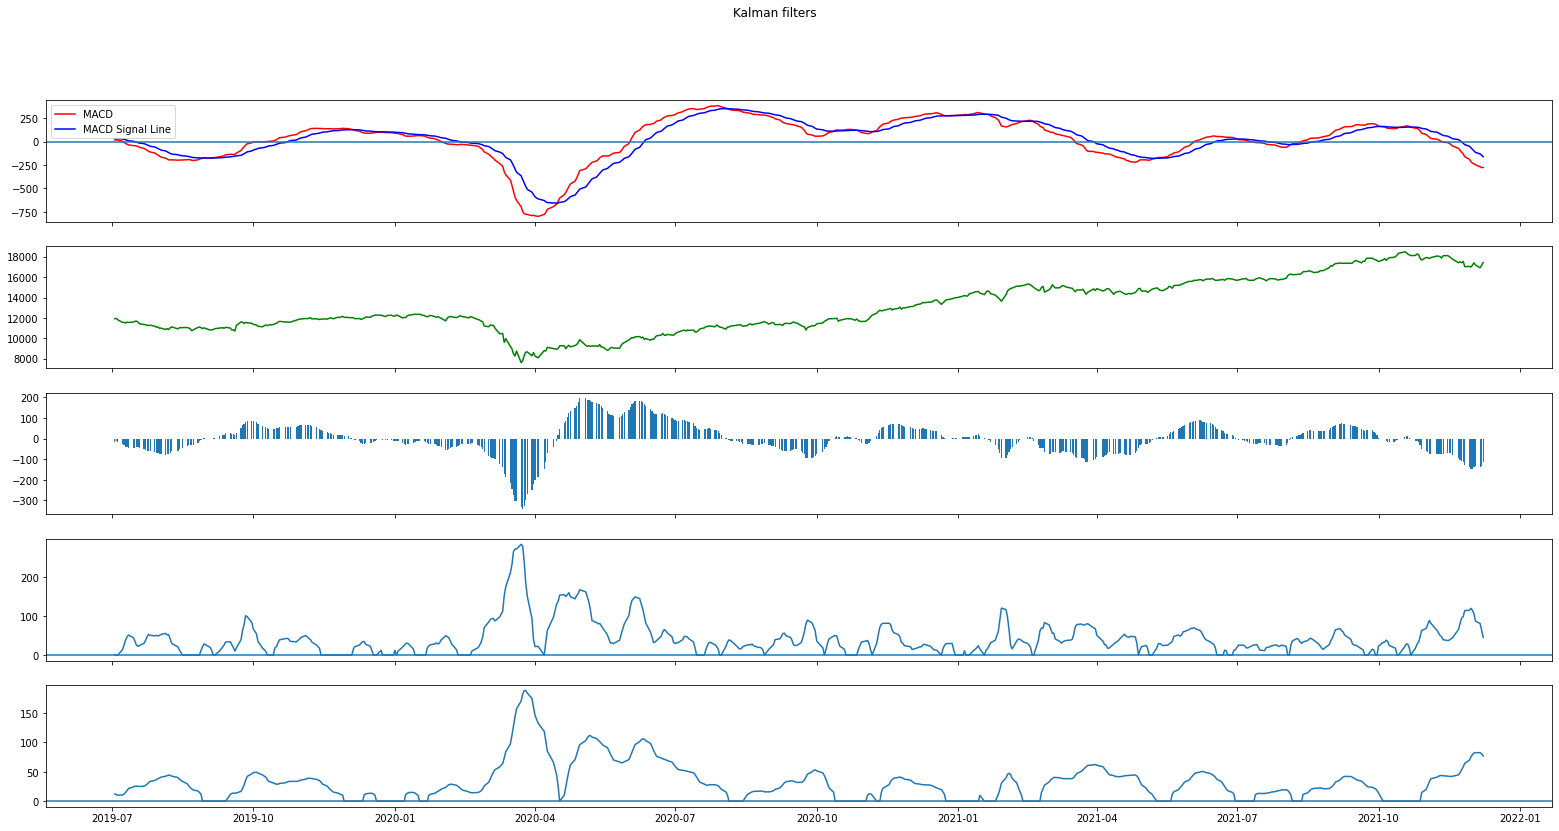

In [17]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACD_26_50_18'][l:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACDs_26_50_18'][l:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[l:], nifty.loc[:, 'MACDh_26_50_18'][l:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[l:], nifty_df.loc[:, 'Close'][l:],'g', label='NH moving avg 50 days')
#ax[1].scatter(nifty_df.loc[nifty_df['Buy_ind'] ==1,:].index[l:],nifty_df.loc[nifty_df['Buy_ind'] ==1,'Close'][l:] ,marker="*")
ax[3].plot(nifty.iloc[:, :].index[l:], nifty.loc[:, 'slope'][l:], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[l:], nifty.loc[:, 'slope_s'][l:], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


In [18]:
l=-1600
m=-1000

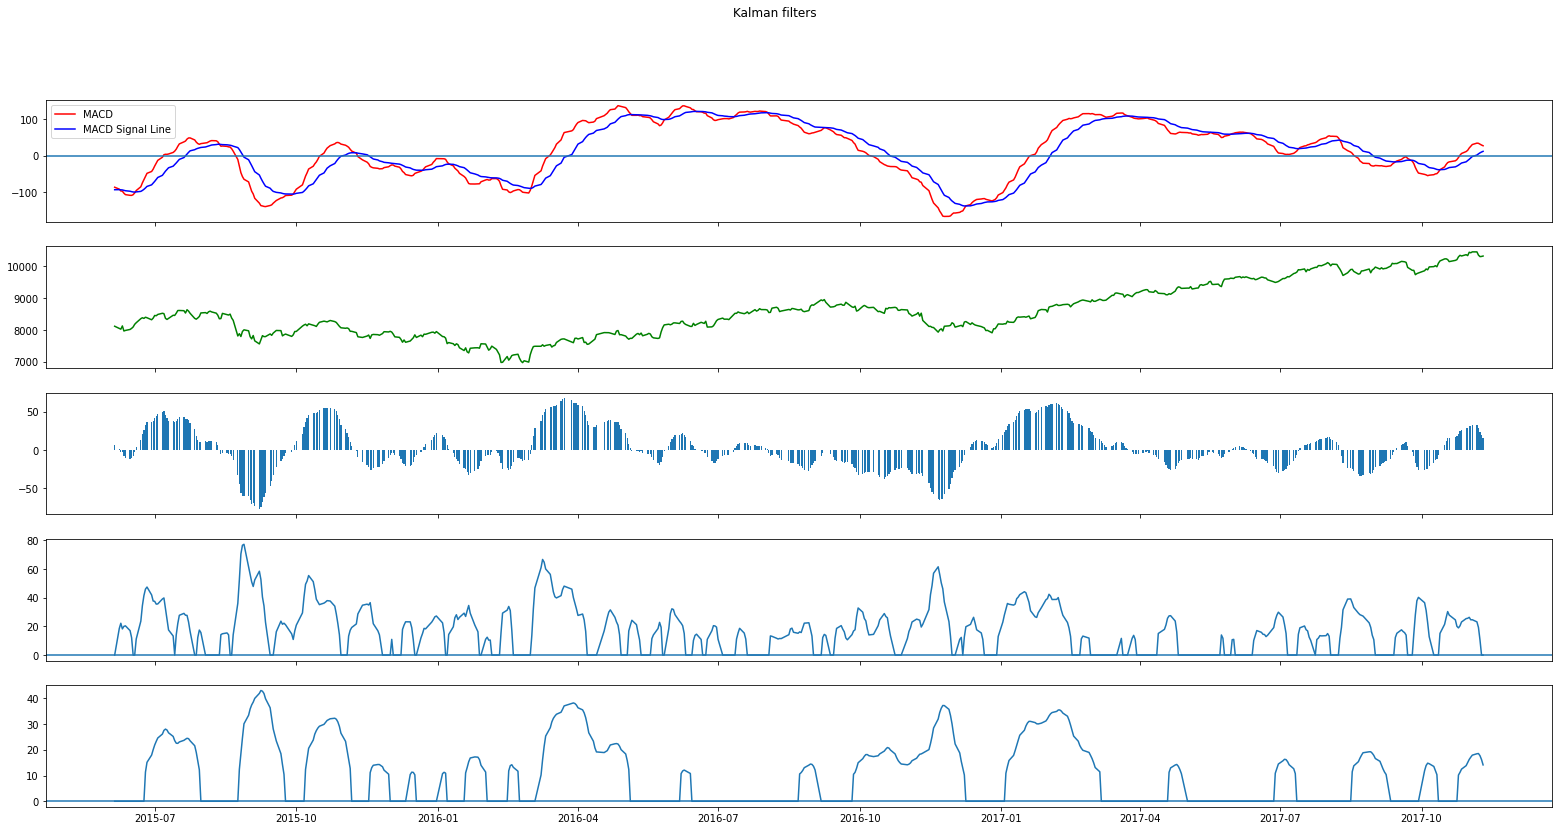

In [19]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[l:m], nifty.loc[:, 'MACD_26_50_18'][l:m],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[l:m], nifty.loc[:, 'MACDs_26_50_18'][l:m],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[l:m], nifty.loc[:, 'MACDh_26_50_18'][l:m], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[l:m], nifty_df.loc[:, 'Close'][l:m],'g', label='NH moving avg 50 days')
#ax[1].scatter(nifty_df.loc[nifty_df['Buy_ind'] ==1,:].index[l:],nifty_df.loc[nifty_df['Buy_ind'] ==1,'Close'][l:] ,marker="*")
ax[3].plot(nifty.iloc[:, :].index[l:m], nifty.loc[:, 'slope'][l:m], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[l:m], nifty.loc[:, 'slope_s'][l:m], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


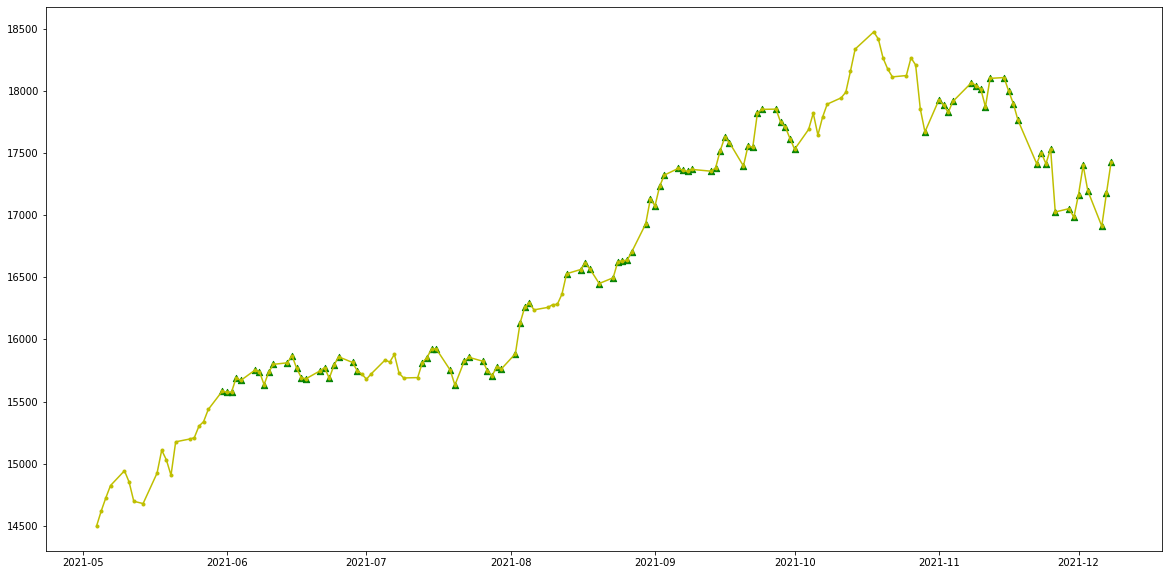

In [20]:
plt.figure(figsize=(20,10))
plt.plot(nifty_df.loc[:, :].index[-150:], nifty_df.loc[:, 'Close'][-150:],'y',marker='.')
plt.scatter(nifty_df.loc[nifty_df['Buy_ind'] ==1,:].index[-100:],nifty_df.loc[nifty_df['Buy_ind'] ==1,'Close'][-100:] ,marker="^",color='g',s=40)
#plt.scatter(nifty_df.loc[nifty_df['Buy_ind'] ==0,:].index[-1000:],nifty_df.loc[nifty_df['Buy_ind'] ==0,'Close'][-1000:] ,marker=".")

plt.show()

In [21]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_26_50_18,MACDh_26_50_18,MACDs_26_50_18,slope,slope_s
date,,,,,,,,,,
2021-12-08,1222.481211,1403.687839,466.335541,1636.85561,1170.520069,-275.31848,-115.420816,-159.897664,45.701213,76.884491


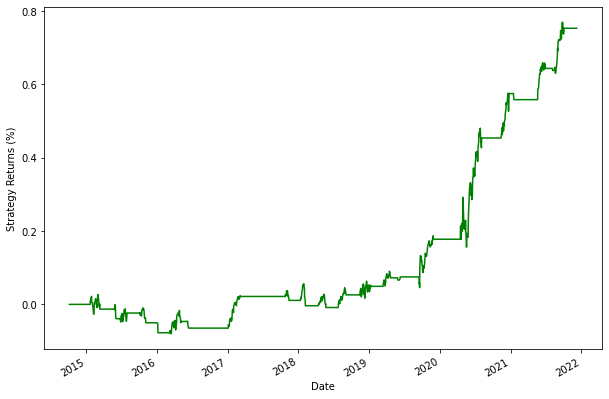

sharpe ratio :  0.03602082351171197
sortino ratio :  0.3436643784077599


In [22]:
nifty['sig']=np.where(nifty['MACDh_26_50_18']>0,1,-1)
nifty['sigs']=np.where(nifty['slope_s']>0,1,-1)
nifty['sigl']=nifty['sig']+nifty['sigs']
nifty['signals']=np.where(nifty['sigl']==2,1,0)
#nifty['signals']=np.where(nifty['sigl']==,1,nifty.signals)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

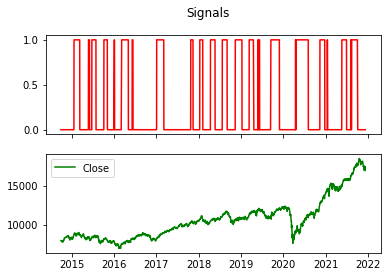

In [23]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


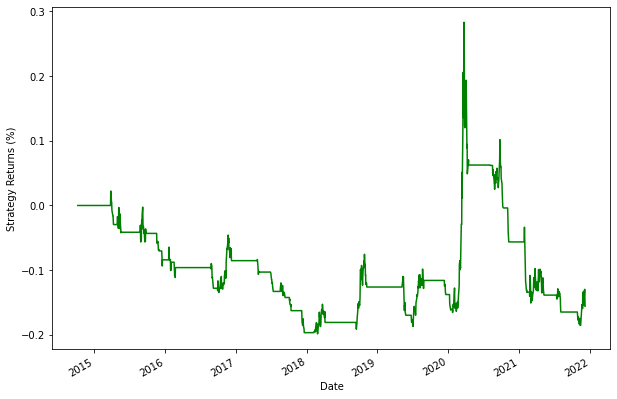

sharpe ratio :  -0.08274619586377757
sortino ratio :  -0.1281780334505051


In [24]:
nifty['sig_s']=np.where(nifty['MACDh_26_50_18']<0,-1,1)
nifty['sigs_s']=np.where(nifty['slope_s']>0,-1,1)
nifty['sigl_s']=nifty['sig_s']+nifty['sigs_s']
nifty['signals_s']=np.where(nifty['sigl_s']==-2,-1,0)
#nifty['signals']=np.where(nifty['sigl']==,1,nifty.signals)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals_s.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

In [25]:
stats = geometric_returns.calc_stats()  # use .calc_stats() on a series to invoke ffn.
stats.display()

Stats for Strategy_F from 2014-10-01 00:00:00 - 2021-12-08 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return    Sharpe    CAGR    Max Drawdown
--------------  --------  ------  --------------
-               -         inf%    -993.50%

Annualized Returns:
mtd     3m      6m      ytd      1y       3y     5y      10y    incep.
------  ------  ------  -------  -------  -----  ------  -----  --------
17.48%  -5.42%  12.43%  176.46%  176.46%  7.33%  13.25%  -      inf%

Periodic:
        daily     monthly    yearly
------  --------  ---------  --------
sharpe  -         -          -
mean    inf%      inf%       -inf%
vol     -         -          -
skew    -         -          -
kurt    -         -          -
best    inf%      inf%       176.46%
worst   -291.19%  -545.50%   -inf%

Drawdowns:
max       avg         # days
--------  --------  --------
-993.50%  -254.24%     521.8

Misc:
---------------  -------
avg. up month    inf%
avg. down month  -23.90%
up year %       

In [26]:
stats.stats

start                    2014-10-01 00:00:00
end                      2021-12-08 00:00:00
rf                                         0
total_return                             NaN
cagr                                     inf
max_drawdown                        -9.93502
calmar                                   inf
mtd                                 0.174806
three_month                       -0.0542033
six_month                           0.124304
ytd                                  1.76458
one_year                             1.76458
three_year                         0.0732636
five_year                           0.132504
ten_year                                 NaN
incep                                    inf
daily_sharpe                             NaN
daily_sortino                            inf
daily_mean                               inf
daily_vol                                NaN
daily_skew                               NaN
daily_kurt                               NaN
best_day  

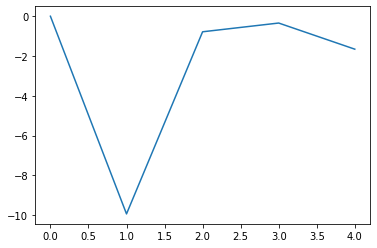

In [27]:
stats.drawdown_details['drawdown'].plot();

In [28]:
stats.display_monthly_returns()

  Year     Jan     Feb      Mar      Apr     May    Jun     Jul     Aug     Sep  Oct          Nov    Dec  YTD
------  ------  ------  -------  -------  ------  -----  ------  ------  ------  -------  -------  -----  ------
  2014    0       0        0        0       0      0       0       0       0     -           0      0     -
  2015    0       0      inf     -545.5   140.09   0       0      27.7   -18.32  0.00       57.55  23.58  -inf
  2016   19.66   -4.5      0        0       0      0       0      16.79    5.74  3.06      -34.02   5.78  1.51
  2017    0       0        0       19.6     0.92   2.72   25.65    1.21    5.77  14.31       0     20.9   130.47
  2018    0      -2.5    -15.15    11.17    0      0       0       0     -17.82  -27.35     16.79   0     -35.87
  2019    0       0        0        0      34.63   3.76  -27.58   -9.14    0     0.00        0     18.82  9.21
  2020    5.84  -37.7   -237.15   -49.79    0      0       0     -23.49   20.63  -106.64  1370.27   0     -59.